In [39]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pathlib import Path

In [2]:
csv_path = Path('data.csv')
df = pd.read_csv(csv_path)
df.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


## Potential questions to investigate
- What seems to correlate with size of crew?
- Does one line have older ships?
- Do lines seem to have ships of a certain size?
- What's the average number of ships per line?

In [41]:
print(df.shape)
print(df.dropna(axis=0, subset=['crew']).shape)

(158, 9)
(158, 9)


In [ ]:
n_ships = len(df.Ship_name)
lines = list(set(df.Cruise_line))
n_lines = len(lines)
print(f'{n_lines=}')
print(f'{df.columns=}')

n_lines=20
df.columns=Index(['Ship_name', 'Cruise_line', 'Age', 'Tonnage', 'passengers', 'length',
       'cabins', 'passenger_density', 'crew'],
      dtype='object')


Text(0.5, 1.0, 'Number of ships vs cruise line')

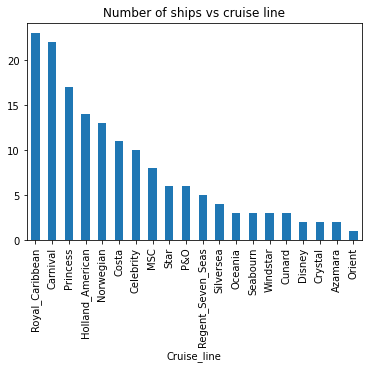

In [4]:
df.Cruise_line.value_counts().plot(kind='bar')
plt.title('Number of ships vs cruise line')

['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density']
3 2


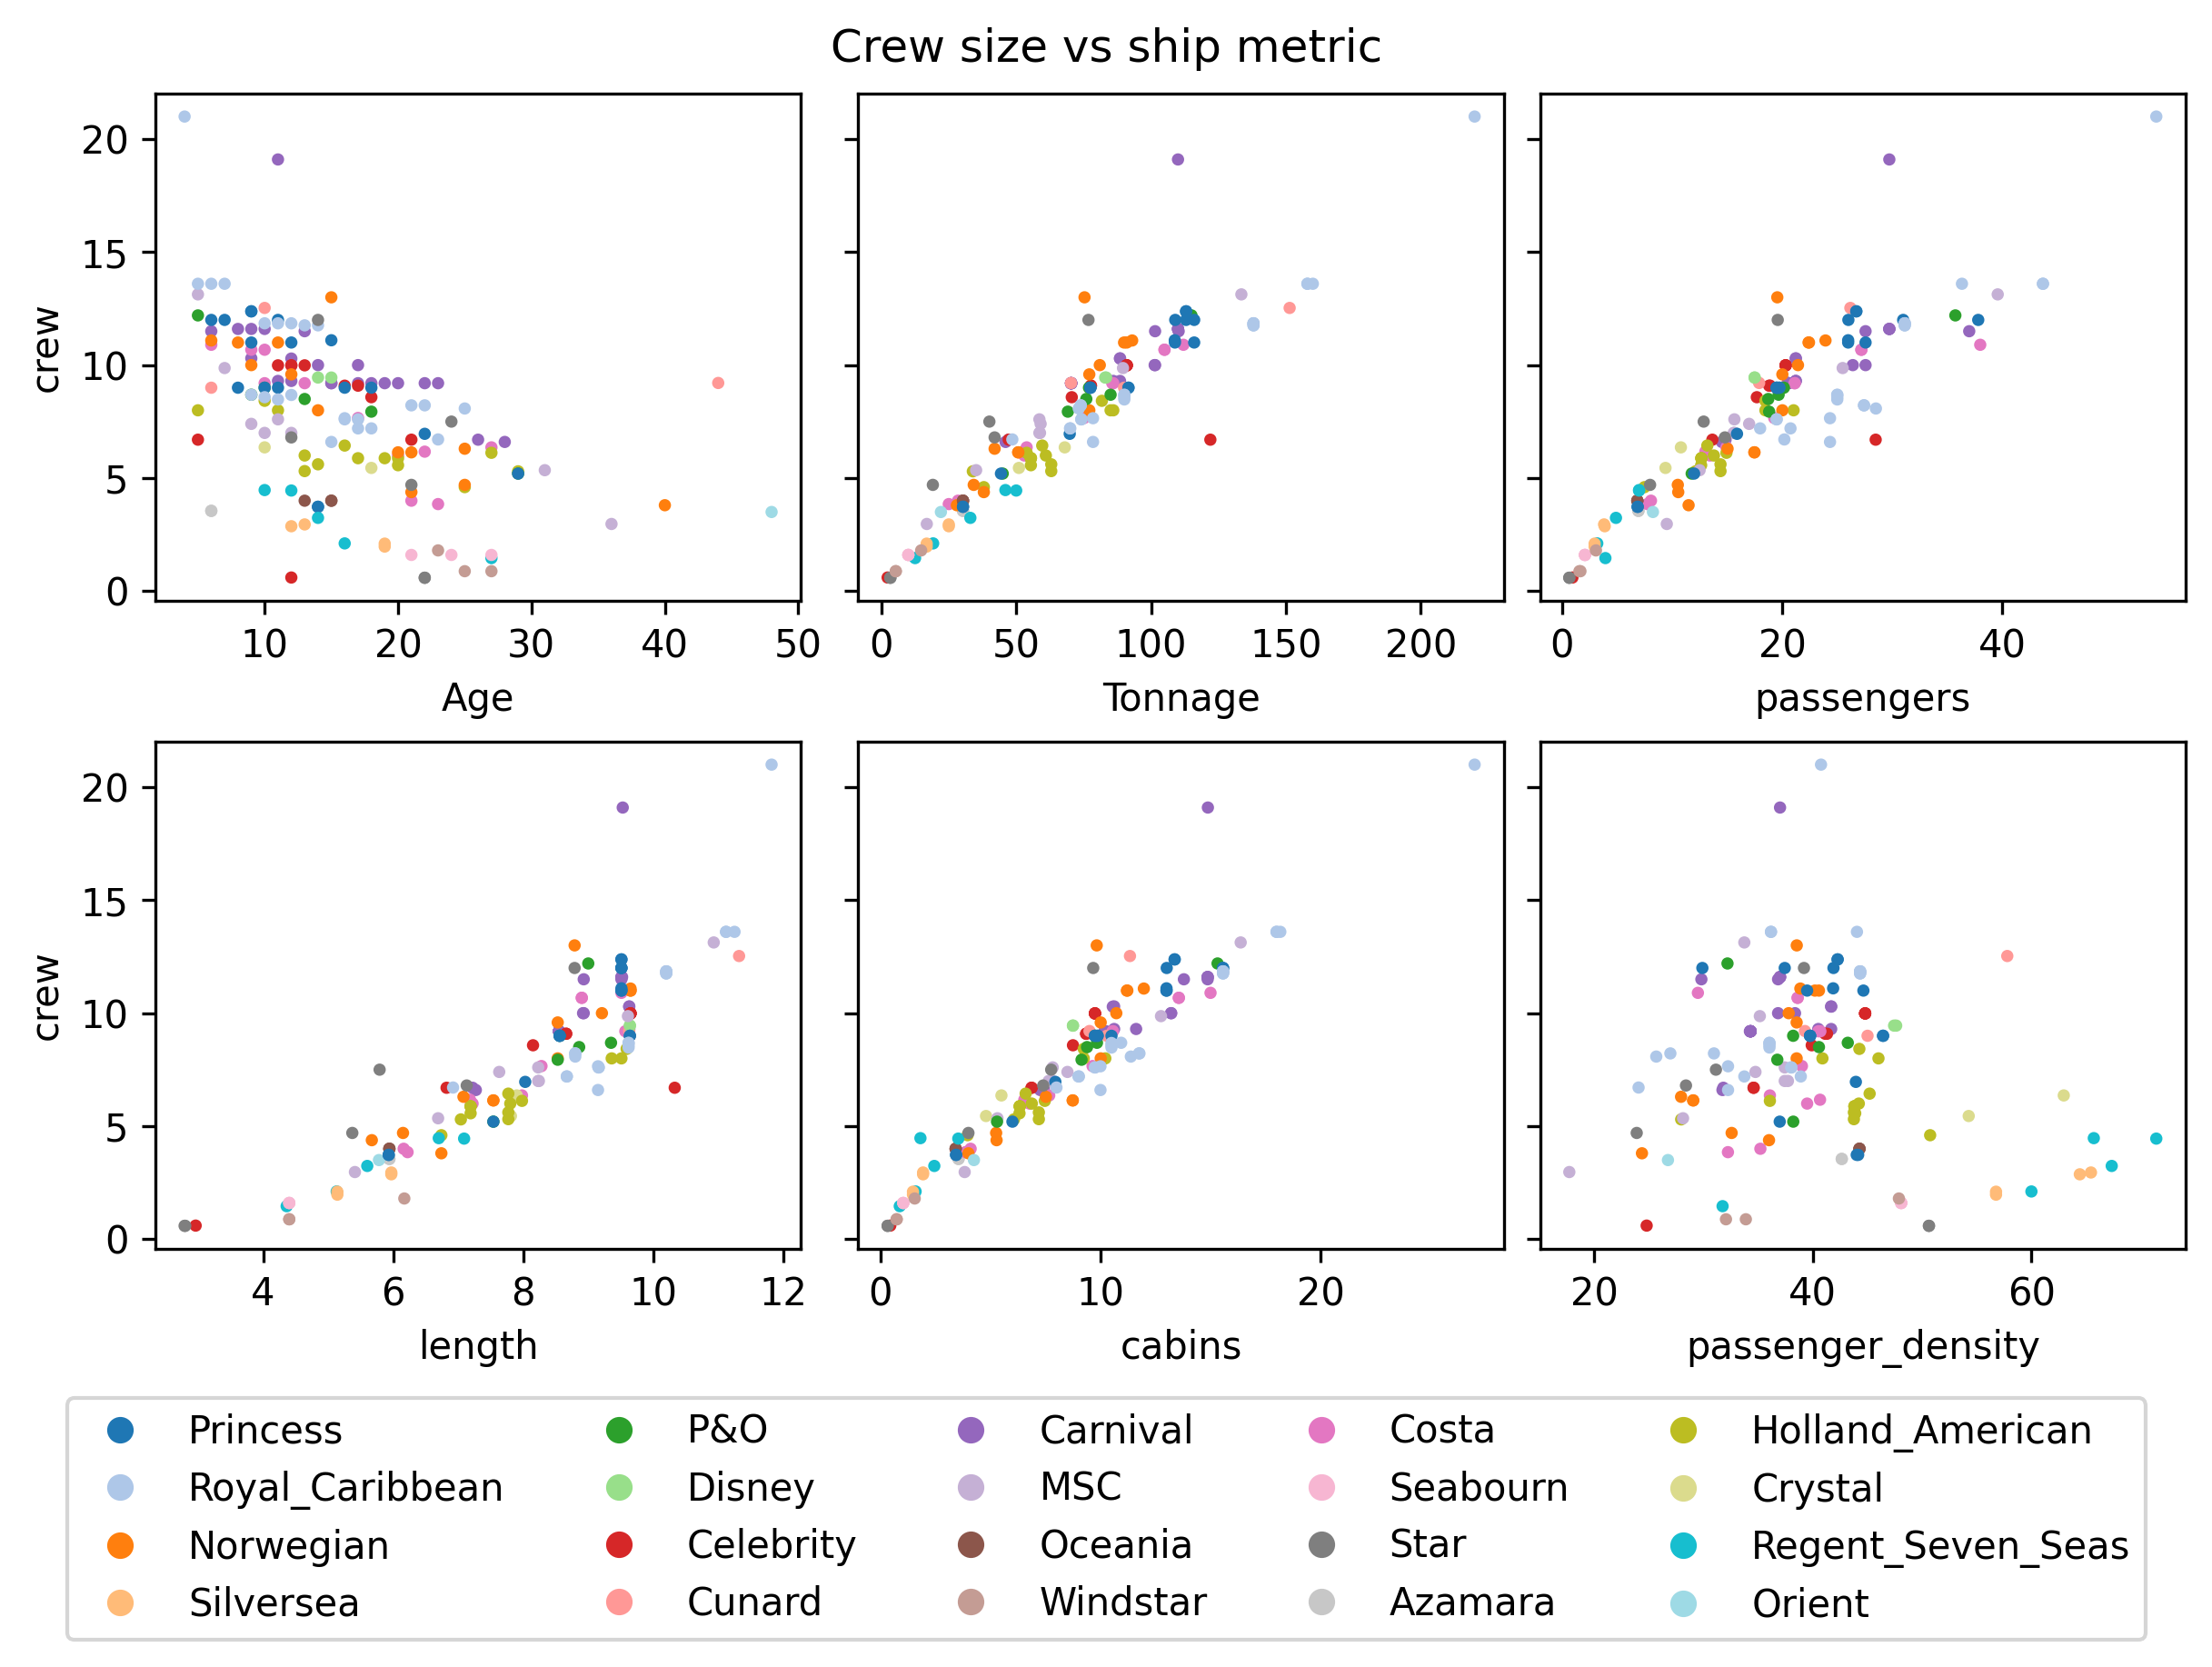

In [38]:
cols = [col for col in df.columns if col not in ['Ship_name', 'Cruise_line', 'crew']]
print(cols)
n_cols = len(cols)
plot_cols = 3
plot_rows = int(math.ceil(n_cols / plot_cols))
print(plot_cols, plot_rows)
fig, axes = plt.subplots(
    nrows=plot_rows, ncols=plot_cols, sharey=True, constrained_layout=True,
    dpi=300, figsize=(8, 5)
)
fig.suptitle('Crew size vs ship metric')
ax = axes.ravel()
line_to_color = {
    line : color for line, color in
    zip(set(df.Cruise_line), mpl.colormaps['tab20'].colors)
}
for i, col in enumerate(cols):
    scatter = ax[i].scatter(
        df[col], df.crew,
        c=df.Cruise_line.map(line_to_color),
        s=5,
    )
    ax[i].set_xlabel(col)
    if i % plot_cols == 0:
        ax[i].set_ylabel('crew')
legendhandle = [
    plt.plot([], marker="o", ls="", color=color)[0]
    for color in list(line_to_color.values())
]
fig.legend(
    legendhandle, list(line_to_color.keys()), bbox_to_anchor=(0.5, 0), loc="upper center", ncol=5)